

## Project 1C: NO2 (ppb) Multilevel Discrete Wavelet Transform of 1D Time Series



## Project Objective 
Identify higher emission of pollutants from on-road vehicles. 
Black Carbon (BC), oxides of nitrogen (NOx) and carbon dioxide (CO2) 

### Use Discrete Wavelet transform and 1D time series to denoise the signal
- Make multilevel decomposition 
- Visualize the Approximation and Details coefficients
- Reconstruct original time series signal
- Reconstruct the Approximation and Details
- Visualize the Approximation and Details
- Reduce data background noise at different scale levels and visualize the results
- Use Scipy signal library to extract actual signal by taking into account background fluctuations during measurements. 

 concentration of pollutants = Peak halfwidth * peak height

### Import required packages

In [1]:
import os
import glob
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.signal import find_peaks
import pywt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
os.getcwd()

'C:\\Users\\bina_\\Dropbox\\Robina Shaheen_PEMS2022\\PEMS_NOx_BC_CO2_ALPR\\ii.dwt'

### Read the data

In [2]:
# base_path=os.path.join ('ii.dwt','data')
# base_path
df = pd.read_csv('./data/2022-09-02/zephyrno.csv')
df.head(3)


,Time,epoch_time,xno,temperature,peakloc,minmax,offset_flag
0,2022-09-02 00:00:00.806918,1.649829e+12,-0.01,44.44,1805.0,30655.0,0.0
1,2022-09-02 00:00:01.205161,1.649829e+12,0.01,44.44,1805.0,30871.0,0.0
2,2022-09-02 00:00:02.001646,1.649829e+12,-0.07,44.44,1805.0,30888.0,0.0


In [3]:
print(df.columns)
print(df.shape)
df = df.ffill().bfill()
#df.info()

Index(['Time', 'epoch_time', 'xno', 'temperature', 'peakloc', 'minmax',
       'offset_flag'],
      dtype='object')
(146188, 7)


In [4]:
print('Empty cells/ zero values:', df.isnull().sum())

Empty cells/ zero values: Time           0
epoch_time     0
xno            0
temperature    0
peakloc        0
minmax         0
offset_flag    0
dtype: int64


### Transform and select data  required for further analysis

In [5]:
df['time2'] = df['Time'].astype(str).str.split().str[1]
# df['time2'] = df['Time'].dt.strftime('%H:%M:%S')
df.tail(5)

,Time,epoch_time,xno,temperature,peakloc,minmax,offset_flag,time2
146183,2022-09-02 23:59:58.042184,1.649913e+12,0.03,37.75,2093.0,31714.0,0.0,23:59:58.042184
146184,2022-09-02 23:59:58.455436,1.649913e+12,-0.07,37.75,1799.0,31709.0,0.0,23:59:58.455436
146185,2022-09-02 23:59:58.995385,1.649913e+12,0.07,37.75,2037.0,31715.0,0.0,23:59:58.995385
146186,2022-09-02 23:59:59.395347,1.649913e+12,-0.06,37.75,1805.0,31710.0,0.0,23:59:59.395347
146187,2022-09-03 00:00:00.095274,1.649913e+12,0.05,37.75,1700.0,31703.0,0.0,00:00:00.095274


In [6]:
# adding delta value =1 to remove most negative values for wavelet analysis
df["NO2"] = df["xno"]+1
df.head(3)

,Time,epoch_time,xno,temperature,peakloc,minmax,offset_flag,time2,NO2
0,2022-09-02 00:00:00.806918,1.649829e+12,-0.01,44.44,1805.0,30655.0,0.0,00:00:00.806918,0.99
1,2022-09-02 00:00:01.205161,1.649829e+12,0.01,44.44,1805.0,30871.0,0.0,00:00:01.205161,1.01
2,2022-09-02 00:00:02.001646,1.649829e+12,-0.07,44.44,1805.0,30888.0,0.0,00:00:02.001646,0.93


In [7]:
# Select NO2 time series for wavelet transform
df2 = pd.DataFrame(df,
                  columns=['time2', 'NO2'])
df2.head(3)

,time2,NO2
0,00:00:00.806918,0.99
1,00:00:01.205161,1.01
2,00:00:02.001646,0.93


In [8]:
df_xno = df[['xno']].agg(['min','max', 'mean'])
print (df_xno)

df_NO2 = df2[['NO2']].agg(['min','max', 'mean'])
print (df_NO2)

           xno
min  -0.110000
max   8.160000
mean  0.044343
           NO2
min   0.890000
max   9.160000
mean  1.044343


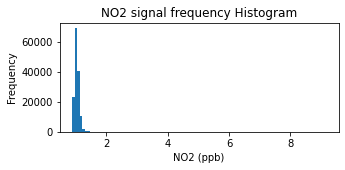

In [9]:
# df2 = pd.DataFrame(df,
#                   columns=['time2', 'IR BC1_ug'])
# from brokenaxes import brokenaxes
fig = plt.figure(figsize=(5, 2))
x= df2['NO2']
plt.hist(x, bins = 100)
plt.gca().set(title='NO2 signal frequency Histogram', 
              xlabel= 'NO2 (ppb)', ylabel='Frequency'); 

### Plot the signal to view magnitude of signal variations

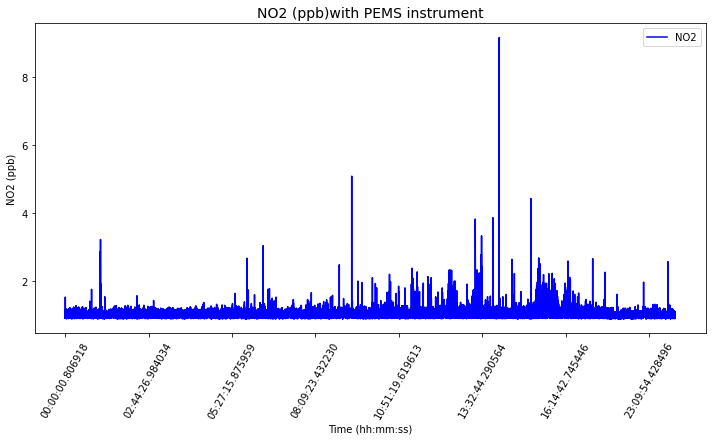

In [13]:
## View NOx timeseries
plt.rcParams["figure.figsize"] = (10, 6)
offset = -.03
# df2 = pd.DataFrame(df,
#                   columns=['Time', 'IR BC1_ug'])

df2.plot(x='time2', y='NO2',color="blue")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('NO2 (ppb)')
plt.xlabel('Time (hh:mm:ss)')
plt.tight_layout()
plt.title("NO2 (ppb)with PEMS instrument", fontsize=14)
plt.savefig('./Results2/NO2_initial_signal.png', dpi=300, 
           bbox_inches='tight')
plt.show()

### Slice  data for wavelet transformations

In [14]:
# t = df2['time2'].astype('datetime64[s]')

t = df2['time2']
s = df2['NO2']
print(type(t))
print(len(t))
t.head(3)


<class 'pandas.core.series.Series'>
146188


0    00:00:00.806918
1    00:00:01.205161
2    00:00:02.001646
Name: time2, dtype: object

## 4. Perform Multi-level Wavelet Decomposition

### (1) Maximum decomposition level

In [16]:
w = pywt.Wavelet('db6')
l = len(s)
f_l = w.dec_len

max_l = pywt.dwt_max_level(data_len=l, filter_len=f_l)

print(max_l)

13


### (2) Wavelet decomposition

In [17]:
coeffs = pywt.wavedec(s,'db6','sym',level=6)

(cA6,cD6,cD5,cD4,cD3,cD2,cD1) = coeffs

### (3) Print the approximation and detail coefficients

In [18]:
print('cA6 = ',cA6)
print('cD6 = ',cD6)

cA6 =  [7.99761754 8.00407187 8.00424379 ... 8.06747641 8.07447977 8.07980673]
cD6 =  [-0.00386853  0.00320247 -0.01318375 ...  0.0925305   0.04823374
  0.02538625]


### (3) length of the coefficients 

In [19]:
print(len(s))
print(len(cA6))
print(len(cD6))

146188
2295
2295


## 5. Visualization of  Approximation and Details Coefficients

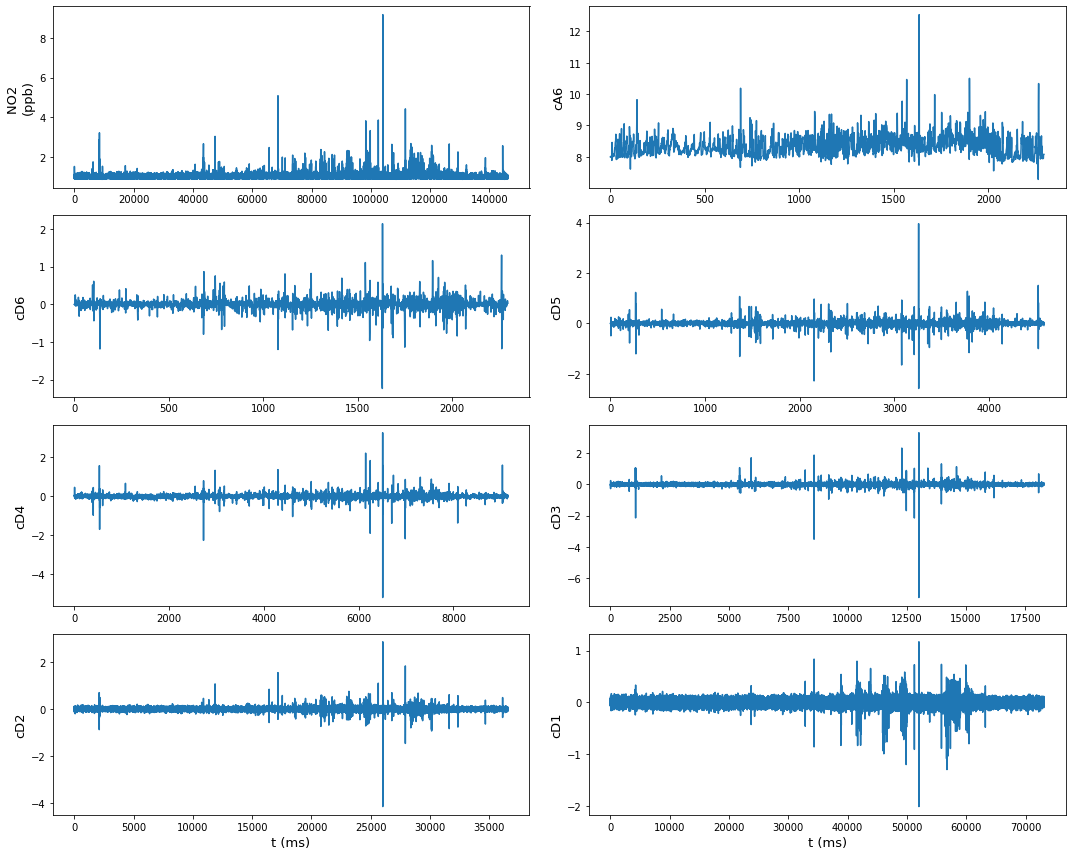

In [20]:
fig,axs = plt.subplots(4,2,figsize=(15,12))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

axs[0,0].plot(s)
axs[0,0].set_ylabel('NO2 \n(ppb)',fontsize=13)

axs[0,1].plot(cA6)
axs[0,1].set_ylabel('cA6',fontsize=13)

axs[1,0].plot(cD6)
axs[1,0].set_ylabel('cD6',fontsize=13)

axs[1,1].plot(cD5)
axs[1,1].set_ylabel('cD5',fontsize=13)

axs[2,0].plot(cD4)
axs[2,0].set_ylabel('cD4',fontsize=13)

axs[2,1].plot(cD3)
axs[2,1].set_ylabel('cD3',fontsize=13)

axs[3,0].plot(cD2)
axs[3,0].set_ylabel('cD2',fontsize=13)
axs[3,0].set_xlabel('t (ms)',fontsize=13)

axs[3,1].plot(cD1)
axs[3,1].set_ylabel('cD1',fontsize=13)
axs[3,1].set_xlabel('t (ms)',fontsize=13)

plt.tight_layout()
plt.savefig('./Results2/NO2_ppb_s_coeffs.png',dpi=300)

plt.show()

## 6. Reconstruct the Signal

In [21]:
s_r = pywt.waverec(coeffs,'db6','sym')
s_r

array([0.99, 1.01, 0.93, ..., 1.07, 0.94, 1.05])

In [22]:
df3= pd.DataFrame(s_r,columns=['recon_s'] )
# df3
# df3.rename(columns={'0':'s_r'}, inplace=True)
df3
# combined_sig = pd.concat([df3, df2])
# combined_sig

,recon_s
0,0.99
1,1.01
2,0.93
3,0.98
4,1.07
...,...
146183,1.03
146184,0.93
146185,1.07
146186,0.94


In [23]:
print(len(s))
print(len(s_r))

146188
146188


### (3) Comparing reconstructed signal with the original one

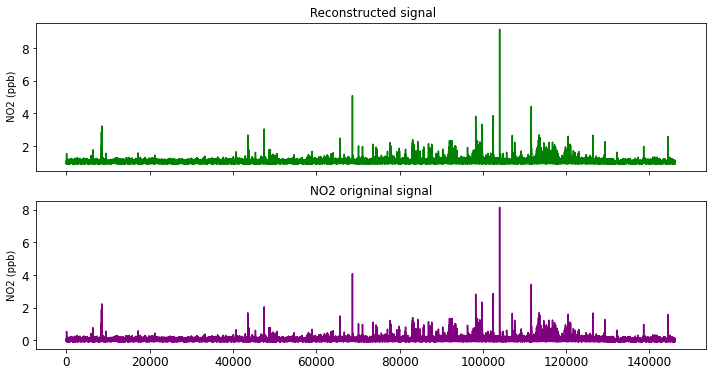

In [26]:
# plot
fig,(ax1,ax2) = plt.subplots(2,1, sharex= True, figsize=(12,6))
# Add x-axis and y-axis
ax1.plot(df3.index.values,
       df3['recon_s'],
       color='green')
ax2.plot(df.index.values,
       df['xno'],
       color='purple')
ax2.set(
    ylabel="NO2 (ppb)",
    title="NO2 origninal signal")
ax1.set(#xlabel = "Time (ms)",
    ylabel=" NO2 (ppb)",
    title=" Reconstructed signal")
# ax.plot(t,s)
# ax.plot(t,s_r)

plt.show()

## 7. Reconstruct Approximations and Details 

### (1) Create zero arrays

In [27]:
cA06 = np.zeros(len(cA6))
cD06 = np.zeros(len(cD6))
cD05 = np.zeros(len(cD5))
cD04 = np.zeros(len(cD4))
cD03 = np.zeros(len(cD3))
cD02 = np.zeros(len(cD2))
cD01 = np.zeros(len(cD1))

In [28]:
print(cA06)

[0. 0. 0. ... 0. 0. 0.]


### (2) Reconstruct Approximations and Details

In [29]:
A6 = pywt.waverec((cA6,cD06,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D6 = pywt.waverec((cA06,cD6,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D5 = pywt.waverec((cA06,cD06,cD5,cD04,cD03,cD02,cD01),'db6','sym')
D4 = pywt.waverec((cA06,cD06,cD05,cD4,cD03,cD02,cD01),'db6','sym')
D3 = pywt.waverec((cA06,cD06,cD05,cD04,cD3,cD02,cD01),'db6','sym')
D2 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD2,cD01),'db6','sym')
D1 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD02,cD1),'db6','sym')

In [30]:
# check the length

print(len(s))
print(len(A6))

146188
146188


### (3) Approximations at other levels

In [32]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (4) Reconstruct signal from approximation and details

In [33]:
s_r = A6 + D6 + D5 + D4 + D3 + D2 + D1

In [34]:
app6= pd.DataFrame(A6,columns=['Approx_6'] )
app6
print(len(app6))
df6_s = app6[['Approx_6']].agg(['min','max', 'mean'])
print (df6_s)

146188
      Approx_6
min   0.865629
max   1.622802
mean  1.044345


In [35]:
# Reconstructed signal from approximation
app3= pd.DataFrame(A3,columns=['Approx_3'] )
app3
print(len(app3))
arr3 = app3.to_numpy()
arr3
# arr3.dtype
# app2= pd.DataFrame(A2,columns=['Approx_2'] )
# app2
df3_s = app3[['Approx_3']].agg(['min','max', 'mean'])
print (df3_s)

146188
      Approx_3
min   0.212242
max   4.080792
mean  1.044343


In [37]:
# app3= pd.DataFrame(A3,columns=['Approx_3'] )
# app3
# combined_df= [app6, t]
recon_s6_t= pd.concat([app6, t], axis = 1)
# recon_s_t['time'] = recon_s_t['time2'].astype('datetime64[s]')

# app3.to_csv('./data/IR_BC1_ug_denoised_signal.csv',index=False)
recon_s6_t.to_csv('./Results2/NO2_ppb_denoised_recon_s6_t.csv',)
recon_s6_t.tail()
# df_s = recon_s_t[['Approx_3']].agg(['min','max'])
# print (df_s)

,Approx_6,time2
146183,1.013650,23:59:58.042184
146184,1.013595,23:59:58.455436
146185,1.013520,23:59:58.995385
146186,1.013428,23:59:59.395347
146187,1.013322,00:00:00.095274


In [38]:
s3= pd.concat([app3, t], axis = 1)
#convert DF to array
#peak_time2=s3["time2"].astype('datetime64[s]') ## to remove ms
peak_time2=s3["time2"].values
print(peak_time2)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_sig2=s3["Approx_3"].values
peak_sig2

['00:00:00.806918' '00:00:01.205161' '00:00:02.001646' ...
 '23:59:58.995385' '23:59:59.395347' '00:00:00.095274']


array([0.98325514, 0.98617104, 0.9906958 , ..., 0.99744922, 1.00277251,
       1.00848728])

In [39]:
df_s3 = s3[['Approx_3']].agg(['min','max', 'mean'])
print (df_s3)

      Approx_3
min   0.212242
max   4.080792
mean  1.044343


In [40]:
# take slice of data
ss6= recon_s6_t[:8114]
print(len(ss6))
print(ss6.head(3))
ss6.tail(3)

8114
   Approx_6            time2
0  1.000414  00:00:00.806918
1  1.001394  00:00:01.205161
2  1.002434  00:00:02.001646


,Approx_6,time2
8111,1.034656,01:07:44.832020
8112,1.034556,01:07:45.294453
8113,1.034464,01:07:45.740604


In [41]:
#convert DF to array
peak_date=ss6["time2"].values
print(peak_date)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_ss6=ss6["Approx_6"].values
peak_ss6

['00:00:00.806918' '00:00:01.205161' '00:00:02.001646' ...
 '01:07:44.832020' '01:07:45.294453' '01:07:45.740604']


array([1.00041369, 1.00139379, 1.00243416, ..., 1.03465615, 1.03455576,
       1.03446446])

In [43]:
# df_s = recon_s_t[['Approx_3']].agg(['min','max', 'mean'])
# print (df_s)

In [ ]:
#convert DF to array
peak_date2=recon_s_t["time2"].values
print(peak_date2)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_sig=recon_s_t["Approx_3"].values
peak_sig

## 8. Visualization of Approximation and Details

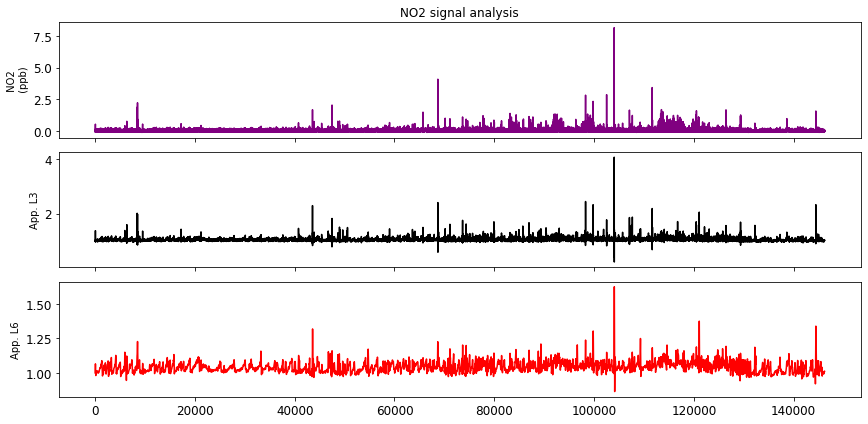

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                    sharex=True, figsize=(12, 6))
# Add x-axis and y-axis
ax1.plot(df.index.values,
         df['xno'],
         color='purple')
# ax2.plot(app2.index.values,
#        app2['Approx_2'],
#        color='orange')

ax2.plot(app3.index.values,
         app3['Approx_3'],
         color='black')
ax3.plot(app6.index.values,
         app6['Approx_6'],
         color='red')

ax1.set(
    ylabel=" NO2 \n (ppb)",
    title="NO2 signal analysis")
# ax2.set(ylabel=" App. L2")
ax2.set(ylabel="App. L3")
ax3.set(ylabel="App. L6")

plt.tight_layout()
plt.savefig('./Results2/NO2_denoised_signal_comparison.png')
plt.show()

### (1) Reconstruct the approximations

In [45]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (2) Check errors

In [46]:
err = sum(s-A6)/len(s)
print(err)

-1.951348514644703e-06


### (3) Peak Identification

In [51]:
array_s6= recon_s6_t.to_numpy()
array_s6
print(len(array_s6))
print(len(recon_s6_t))
print(recon_s6_t.dtypes)

146188
146188
Approx_6    float64
time2        object
dtype: object


In [ ]:
##use subset of data to show peak identification
df2_rep= df2[2000:2600]
# A5s1=A3[1000:3060]
# A5s1.shape
# x1_array = np.arange(1000,3060)
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
#convert DF to array
df2_date_rep=df2_rep["time2"].values
# print(peak_date_rep)
# peak_date=recon_s_t["time"].values
# print(peak_date)
NO2_rep=df2_rep["NO2"].values
NO2_rep
y4_array=NO2_rep
x4_array= df2_date_rep
plt.plot(x4_array, y4_array)
plt.xticks(rotation =60)
plt.title("Original data", fontsize= 14, color = 'black')
plt.ylabel('NO2 (ppb)', fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
plt.tight_layout()
plt.savefig('./results/NO2_orig_subset_sig.png', dpi=300)
plt.show()

In [52]:
#convert fulls signal at APP6 to array
peak_date6=recon_s6_t["time2"].values
peak_s6=recon_s6_t["Approx_6"].values
peak_s6
y6_array=peak_s6
x6_array= peak_date6

In [ ]:
# # blocked to save time used in plotting data
# plt.plot(x6_array, y6_array)
# plt.xticks(rotation =60)
# plt.title("Denoised signal with wavelet transformation at app. L6",
#           fontsize= 15, color = 'black')
# plt.ylabel('NO2 (ppb)', fontsize= 13)
# plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(500))
# plt.tight_layout()
# plt.savefig('./Results/NO2_denoised_A6_sig.png', dpi=300)
# plt.show()

In [ ]:
#smaller subset for peak identification algorithm
peaks, properties = find_peaks(y6_array, prominence=2, width=20)
sig_peaks, _ = signal.find_peaks(y6_array)
promin = signal.peak_prominences(y6_array, sig_peaks)[0]
print(len(promin))
# promin
plt.plot(promin)

In [ ]:
half_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 0.5)
full_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 1)


plt.plot(x6_array, y6_array)
plt.plot(sig_peaks, y6_array[sig_peaks], "*", color = 'red')
contur_height = y6_array[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y6_array[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(800))
plt.xticks(rotation =60)
plt.ylabel('NO2 (ppb)', fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.tight_layout()
#small subset for report
plt.savefig('./results2/NO2_peak_area_s6_report2.png', dpi=300)
plt.show()

In [ ]:
print(len(x6_array))

In [ ]:
# print('Half width of peaks:', half_peak_res[0])
HWpeak = np.asarray(half_peak_res)
HWpeak_NO2 = pd.DataFrame(HWpeak)
# print(HWpeak_BC.head(3))
HWpeak_NO2.to_csv('./Results2/full_NO2_HWpeak.csv')

# print('Full width of peaks:', full_peak_res[0])
FWpeak = np.asarray(full_peak_res)
FWpeak_NO2 = pd.DataFrame(FWpeak)
FWpeak_NO2.to_csv('./Results2/full_NO2_FWpeak.csv')
print('Height of peaks:',contur_height)
contur_height_NO2 = pd.DataFrame(contur_height)
contur_height_NO2.to_csv('./Results2/full_NO2_peak_height.csv')
# contur_height.to_csv('./results/BC_peaklength.csv')
print(len(contur_height))
print(len(half_peak_res[0]))
print(type(half_peak_res))
print(type(full_peak_res))
print(type(HWpeak))
print(type(FWpeak))
print(type(contur_height))